# Case Study 9 - Autoregression
## ECE204 Data Science & Engineering

In [1]:
import pandas as pd
import numpy as np

## Reading the Data

Let's look at a dataset that describes the minimum daily temperatures over 10 years (1981-1990) in the city of Melbourne, Australia.

The units are in degrees Celsius and there are 3,650 observations. The source of the data is the Australian Bureau of Meteorology.

Note: This dataset ignores a day in leap years for consistent number of observations (365) in each year.

In [2]:
df = pd.read_csv("daily-min-temp-melb.csv", index_col=0, parse_dates=True) 
df.head()

,min_temp
date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [3]:
df.shape

(3650, 1)

In [4]:
# fill in missing values
idx = pd.date_range('1981-01-01', '1990-12-31')
df = df.reindex(idx)
df.bfill(inplace=True)

In [5]:
df.shape

(3652, 1)

## Visualizing Data

Let's visualize what the minimum daily temperature data looks like. Alongside with it, we also plot the rolling mean to smooth out variations in each 365-day window. <br>

**NOTE:** The rolling mean appears to start high and then stabilize after about 365 days because in the first year, it just averages the observations it does have in that window ($\leq$365). This makes the rolling mean higher for that period since the temperates are higher early on.

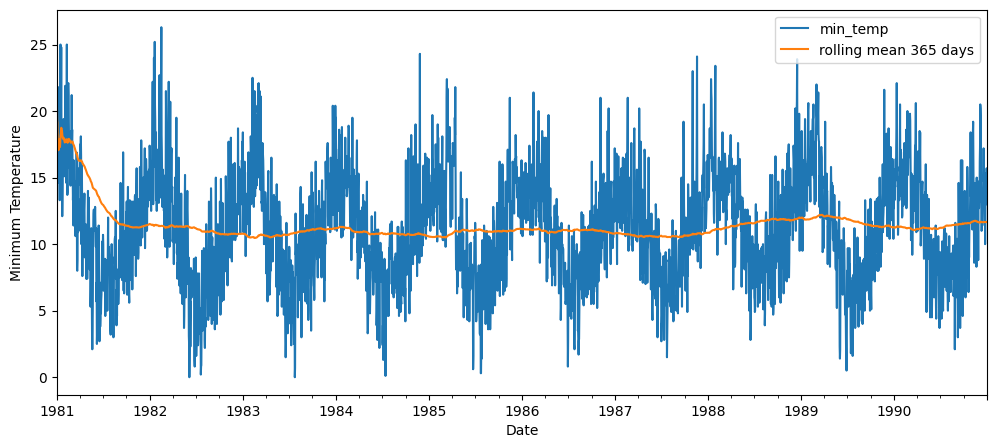

In [6]:
# Plotting the original data and the 365 day rolling mean
ax = df.plot(figsize=(12,5));

df.min_temp.rolling("365d").mean().plot(ax=ax, label='rolling mean 365 days')
#df.min_temp.rolling("7d").mean().plot(ax=ax, label='rolling mean 7 days')
ax.set_ylabel("Minimum Temperature")
ax.set_xlabel("Date")
ax.legend()

Autoregression relies on the relationship between a value at a particular time step (say, t), and the values at earlier time steps (t-1, t-2, and so on) or **lags**. Using a lag plot, we can visualize how the previous time step relates with the current one.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

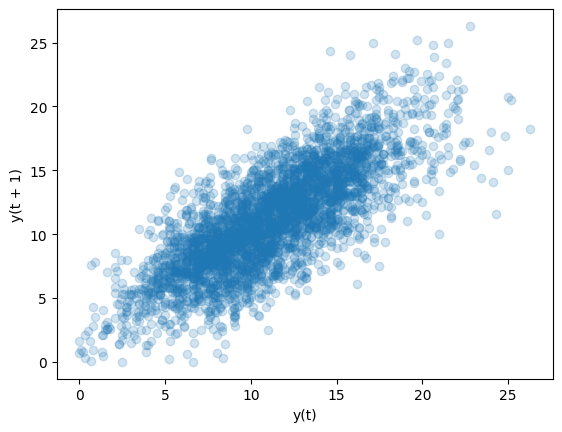

In [7]:
from pandas.plotting import lag_plot

# Visualizing the lag plot.
# By default lag=1
lag_plot(df.min_temp, alpha=0.2)

We can visualize lag plot at higher lags as well!

<Axes: xlabel='y(t)', ylabel='y(t + 2)'>

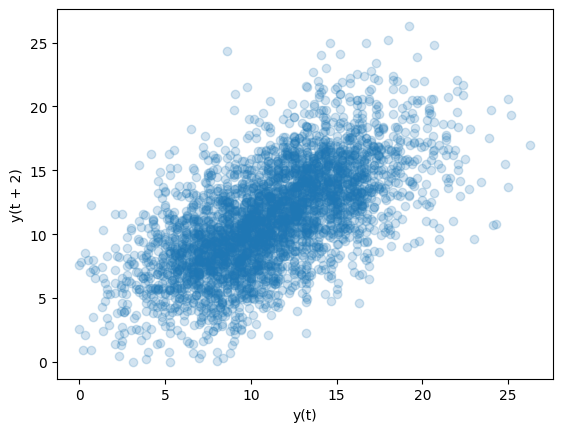

In [8]:
lag_plot(df.min_temp, lag=2, alpha=0.2)

<Axes: xlabel='y(t)', ylabel='y(t + 365)'>

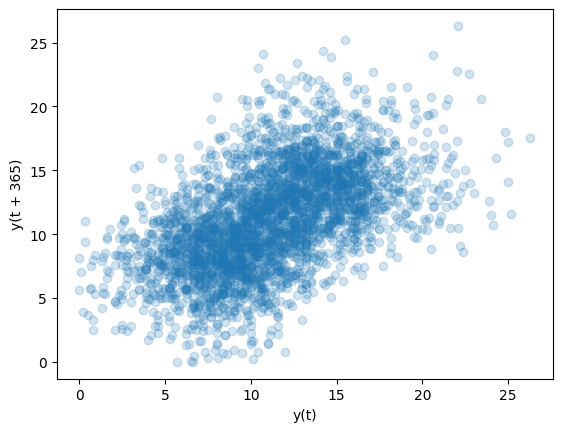

In [9]:
lag_plot(df.min_temp, lag=365, alpha=0.2)

We see that while the lag plot at lag=1 does indicate a somewhat linear relationship between minimum temperature values at time steps t, and t-1 (or alternatively at t+1 and t, whichever way you want to look at it!). However, this relation becomes weaker as lags increase.

## Autoregression Model

We will now use a simple Autoregression model for the task of forecasting ahead.
We have minimum-temperature data for 10 years, so let's say we want to predict the last 7 days of this 10-year period using the other observations before it (3650-7 = 3643)

In [10]:
# Defining the train set, all days but the last 7: 1981-01-01 to 1990-12-24
dftrain = df.loc[:'1990-12-24']
dftrain.tail()

,min_temp
1990-12-20,15.4
1990-12-21,13.1
1990-12-22,13.2
1990-12-23,13.9
1990-12-24,10.0


In [11]:
# The test set: The last 7 days: 1990-12-25 to 1990-12-31
dftest = df.loc['1990-12-25':].copy()
dftest

,min_temp
1990-12-25,12.9
1990-12-26,14.6
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


**Note:** The `statsmodels` library has autoregression models, but the syntax is slightly different from that of `sklearn` . In particular, while defining the model object, we pass in the time-series we want to forecast in addition to the`lags` argument.

In [12]:
from statsmodels.tsa.ar_model import AutoReg
#from datetime import datetime

model = AutoReg(dftrain.min_temp, lags = 180)
model_fit = model.fit()

print('Lag:', model_fit.ar_lags)
print('Coefficients:', model_fit.params)

yhat = model_fit.predict(start='1990-12-25', end='1990-12-31')

Lag: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180]
Coefficients: const            3.460186
min_temp.L1      0.558080
min_temp.L2     -0.096682
min_temp.L3      0.027392
min_temp.L4      0.019757
                   ...   
min_temp.L176    0.003234
min_te

### Visualizing our predictions

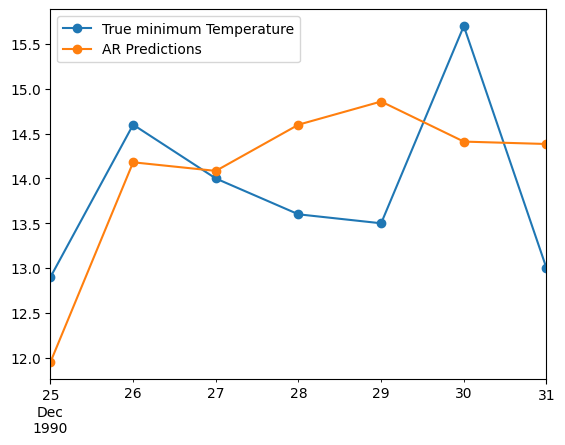

In [13]:
# add predictions to the test dataframe
dftest["predictions"] = yhat

ax = dftest.min_temp.plot(marker='o', label="True minimum Temperature")
dftest.predictions.plot(ax=ax, marker='o', label='AR Predictions');
ax.legend()

We can now check if our predictions improve if we consider more time lags of observations for Autoregression. (Check by setting maxlag=2, 3, 365 etc.)